# Lindbladian calculation of cavity dephasing time 💣

In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import datetime
import csv
from scipy.optimize import curve_fit
from tools import proj
from multiprocessing import Pool
from itertools import product
from matplotlib import ticker, cm

plt.style.use('ggplot')
%matplotlib inline

## 👉 What is the Lindblad master equation?
Normally, we evaluate the time evolution of a quantum system with the *Schrodinger equation*. Unfortunately, although it is *possible* to describe everything with the schrodinger equation, it is not always feasible to do so. Take, for example, interaction with the environment outside our experiment, we could model this interaction with the schrodinger equation but to do so we need to be able to model the quantum behaviour of the environment, and that is hard to impossible. A better approach is to use a *master equation* (the *Lindblad master equation*, to be precise), it allows usu to model the quantum dynamics of an open system, i.e. non-unitary operation on our quantum system. If we had, for example, a qubit that has some chance to collapse on the ground state every so often (non-coherently, that is) we could model such thing with the master equation.

This is the **Lindblad master equation** in it's full form:
$$\dot{\rho} = -\frac{i}{\hbar}[H,\rho] + \sum_{n,m=1}^{N^2-1} h_{nm}(A_n \rho A^\dagger_m - \frac{1}{2}\{A^\dagger_mA_n, \rho\})$$
But is better solved (for us) with it's diagonal form
$$\dot{\rho} = -\frac{i}{\hbar}[H,\rho] + \sum_{i=1}^{N^2-1} \gamma_i(L_i \rho L^\dagger_i - \frac{1}{2}\{L^\dagger_i L_i, \rho\})$$
Where $\gamma_i$ is the rate at which this process occurs and $L_i$ are the *Lindblad operators* (or *jump operators*),
$$L_i = \sum_{j=1}^{N^2-1}u_{ji}A_j$$
$u$ is the unitary transformation that diagnelizes $h$, i.e. $u^\dagger h u$ is a diagonal matrix.

You can approximate this expression to make it simpler using the Born, Markov, and Secular approximations, and get
$$L_A[\rho]=2A O A^\dagger - A^\dagger A O - O A^\dagger A$$
$$\dot{\rho} = - \frac{i}{\hbar}[H, \rho] + \sum_A \frac{\gamma_A}{2}L_A[\rho]$$
Where each A is a non-unitary operator that happens with rate $\gamma$

#### 🔹 Defining parameters

In [184]:
wc       = 0               # cavity frequency (MHz)
wa       = 0               # atom frequency   (MHz)
g        = 2*np.pi*0.2     # coupling strength
chi_e    = 2*np.pi*0.05*0
chi_f    = 2*np.pi*0.1*0
kappa    = 1e-6            # cavity dissipation rate
gamma    = 0.01            # atom dissipation rate
N        = 5               # number of cavity fock states
qub_lvls = 3
n_th_a   = 0.03            # avg number of atom bath excitation
n_th_c   = 0.01            # avg number of cavity bath excitation
mu       = [0.9995, 0.99]  # Measurement error rate [|g> error, |e> error]

alpha_T  = -2*np.pi*200
K        = -2*np.pi*4e-3
chi2     = -2*np.pi*20e-3

tlist = np.linspace(0, 150, 500)  # MUST: max(tlist) >> 1/chi

#### 🔹 Defining Hamiltonian, initial state and operators

In [185]:
# intial state
cav0  = (qt.basis(N, 1) + qt.basis(N, 0))/np.sqrt(2)  # |0> + |1>
qub0  = qt.basis(qub_lvls, 0)                         # |g>

psi0  = qt.ket2dm(qt.tensor(cav0, qub0))  # |0> + |1> x |g>

psi_e = qt.ket2dm(qt.tensor(cav0, qt.basis(qub_lvls, 1)))  # |0> + |1> x |e>
psi_f = qt.ket2dm(qt.tensor(cav0, qt.basis(qub_lvls, 2)))  # |0> + |1> x |f>

# operators
a   = qt.tensor(qt.destroy(N), qt.qeye(qub_lvls))
sm  = qt.tensor(qt.qeye(N), qt.destroy(qub_lvls))
e   = qt.tensor(qt.qeye(N), qt.basis(qub_lvls, 1))
f   = qt.tensor(qt.qeye(N), qt.basis(qub_lvls, 2))

ad  = a.dag()
smd = sm.dag()
ed = e.dag()
fd = f.dag()

# Dispersive hamiltonian
H = wc*ad*a + wa*smd*sm + ad*a*( chi_e*e*ed + chi_f * f*fd ) +  chi2*ad*ad*a*a*smd*smd*sm*sm + (alpha_T/2)*smd*smd*sm*sm + (K/2)*ad*ad*a*a  # Wc ad*a + Wa |e><e| + ad*a * (chi_e |e><e| + chi_f |f><f|)

#### 🔹 Defining collapse operators
Now this is the interesting part. Each operators in the list `c_ops` will be evaluated as if it's operation is occouring at some specified rate. So the third one, for example, the $\hat{\sigma}_z$ is responsible for qubit non-coherently relaxing.

In this test, these are the collapse operators:
  * **Cavity relaxation:** $\sqrt{K(1 + n_{th})} \hat{a}\ \rightarrow$               The cavity loses a photon due to thermal noise
  * **Cavity excitation:** $\sqrt{Kn_{th}} \hat{a}^\dagger \quad\quad\rightarrow$  The cavity gains a photon due to thermal noise
  * **Qubit relaxation:** $\sqrt{\gamma(1 + n_{th})} \hat{\sigma}_-\ \rightarrow$               The atom loses a photon due to thermal noise
  * **Qubit excitation:** $\sqrt{\gamma n_{th}} \hat{\sigma}_+ \quad\ \ \quad\rightarrow$  The atom gains a photon due to thermal noise

In [186]:
c_ops = [
    np.sqrt(0.5*kappa*(1+n_th_c)) * a,     # cavity relaxation (Thermal)
    np.sqrt(0.5*kappa*n_th_c) * a.dag(),   # cavity excitation (Thermal)
    np.sqrt(0.5*gamma*(1+n_th_a)) * sm,    # qubit relaxation  (Thermal)
    np.sqrt(0.5*gamma*n_th_a) * sm.dag(),  # qubit excitation  (Thermal)
]

Since the thermal excitations cause the problem, we want to remove them as much as possible. One way is to cool down the system more and more, but obviouly we would reach our limit pretty quickly.
A different approach would be to measure the qubit repeatedly, and if we measure it to be in the excited state, put it back into the ground state. We can do this by projecting the qubit-cavity state into this state:
$$\rho_{new} \leftarrow (I \otimes |g><g|)\ \rho_{old}\ (I\otimes|g><g|) + (I \otimes |e><e|)\ \rho_{old}\ (I \otimes |e><e|)$$
This comes from putting the qubit into the ground state, and adding the cavity state of the ground part (of the qubit, i.e. the cavity state if the qubit were grounded) together with the cavity state of the excited part, like so
$$\text{qubit} \otimes\text{cavity} \rightarrow \text{ground} \otimes (\text{cavity}_{ground} +  \text{cavity}_{ground})$$
Now let's put this into code

### 🔹 Simulate an experiment
With the `sim_meas` function we simulate an experiment, where `psi0` is the initial state, `H` is the Hamiltonian and `dt` is the time between measurements (in $us$).

In [187]:
def sim_meas(psi0, H, dt):
    """Simulate the system and do a measurment each dt time step, each measurment project the qubit state to the ground state"""
    states = []
    for t in np.arange(0, len(tlist), dt):
        psi_meas   = proj(states[-1], N, qub_lvls, mu) if states else psi0
        time_range = tlist[t:min(t+dt, len(tlist))]

        output = qt.mesolve(H, psi_meas, time_range, c_ops)
        states.extend(output.states)
    return states

Let's test it out with some experiment

In [199]:
states = sim_meas(psi0, H, len(tlist)//10)
n = [abs(np.trace(state*(psi0+psi_e+psi_f*0))) for state in states]

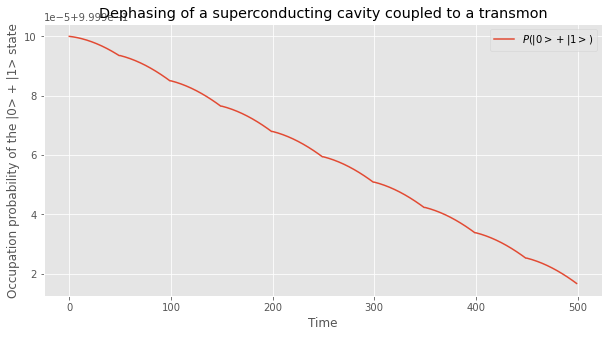

In [200]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(n)            # P(|0>+|1> X |g> + |0>+|1> X |e>)

ax.legend(["$P(|0>+|1>)$"])
ax.set_xlabel('Time')
ax.set_ylabel('Occupation probability of the |0> + |1> state')
ax.set_title('Dephasing of a superconducting cavity coupled to a transmon');

#### Fitting the curve
We can use a linear fit to find the life-time of the cavity. Since we know that
$$e^{-\frac{1}{\tau}x} \approx 1 - \frac{1}{\tau}x + \dots$$
We can fit the curve with a line $y = mx + b$ and from that get the life time as
$$\tau = -\frac{1}{m}$$
Let's put it into code

The life-time of the cavity is 901153.329


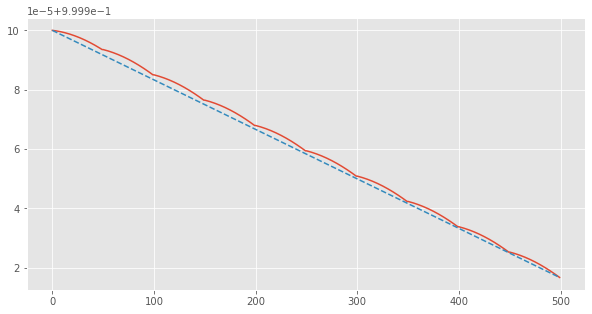

In [201]:
m = -(n[0]-n[-1])/tlist[-1]  #  Slope of the line from the first to the last point
plt.figure(figsize=(10,5))
plt.plot(n)
plt.plot(m*tlist+n[0], '--')
print(f'The life-time of the cavity is \33[35m\33[1m{-.5/m:.3f}\33[0m')

### What's going on?
In this example, the transmon starts at the ground state, while the cavity starts at the superpositon $|0> + |1>$, since we give the cavity energy, the phase of the $|1>$ changes and the cavity state "rotates" from $|0> + |1>$ to $|0> - |1>$ and so forth. While we can easily see the oscilations, it is not so clear why would the cavity decay, after all, we set the cavity dissipation to be 0, it shouldn't have losses, so what's going on? Finally, we get to the real problem with **dephasing**. The reason the cavity oscilation decay is that we loose our knowladge of the frequency of the cavity, and if we don't know the frequency, we can't know after a while weather the cavity is in the state $|0> + |1>$ or $|0> - |1>$, so eventally it becomes a constant 50/50% of either state (i.e. the cavity approaches the state $\frac{1}{2}(|0>+|1>)(<0|+<1|) + \frac{1}{2}(|0>-|1>)(<0|-<1|)$).

But why do we loose our knowledge of the cavity frequency? Well, even though the cavity and the transmon are off resonance (so there aren't rabi oscilations between them) they are still coupled. Under the dissipative approximation, we can think of it as if **the state of the transmon affects the frequency of the cavity**, so if for example the cavity frequency is $\omega$ when the qubit is at the ground level, it would be $\omega + \chi$ when the transom is excited. And the transmon get's excited due to thermal fluctuation, so the frequency of the cavity changes and we get the dephasing.

### The effect of the time between measurments on the dephasing rate
We can plot the dephasing rate (and the life-time) of the cavity vs the time between measurments ($dt$) and we see an interesting behivour. We can see that the life-time approachas infinity when $dt << \chi$.

In [202]:
def calc_lifetime(tup):
    """Calculate the lifetime of the cavity given the coupling (chi) and the time between measurements (dt). Given in the tuple (dt, chi)"""
    dt, chi_e = tup
    H = wc*ad*a + wa*smd*sm + ad*a*( chi_e*e*ed + chi_f * f*fd)
    
    states = sim_meas(psi0, H, dt)

    qub = psi0 + psi_e + psi_f  # |g> + |e> + |f>
    
    # Initial and final states of the cavity (projected onto the)
    init  = abs(np.trace(states[0]*qub))
    final = abs(np.trace(states[-1]*qub))
    
    m = (final-init)/tlist[-1]  # m = dy/dx
    return -0.5/m

### Calculating the life-time of different $\chi_e$ and $dt$ values

In [181]:
t_tot    = 140  # The largest value of dt to simulate (in micro-seconds)
t_max    = np.argmin(abs(tlist-t_tot))

dt_pnts  = min(20, t_max)  # Number of values of dt to simulate  (can't be more than the amount of points there are in tlist)
chi_pnts = 20               # Number of values of chi_e to simulate

dt_list    = np.linspace(2, t_max, dt_pnts, dtype=int)
chi_e_list = np.linspace(0, 0.15, chi_pnts)

param_range = list(product(dt_list,chi_e_list))

with Pool(20) as p:
    results = p.map(calc_lifetime, param_range)

tau = np.reshape(results, (dt_pnts, chi_pnts))  # The life time of the cavity

## ⚠ Windows warning ⚠
I'm pretty sure that the multi-processing functionality doesn't work on Windows (in the lab I ran it from a Linux subsystem on Windows). If that's the case, simply replace
```python
with Pool(20) as p:
    results = p.map(calc_lifetime, param_range)
```
with
```python
results = list(map(calc_lifetime, param_range))
```
be warned that it would take much longer though

#### Plotting the results

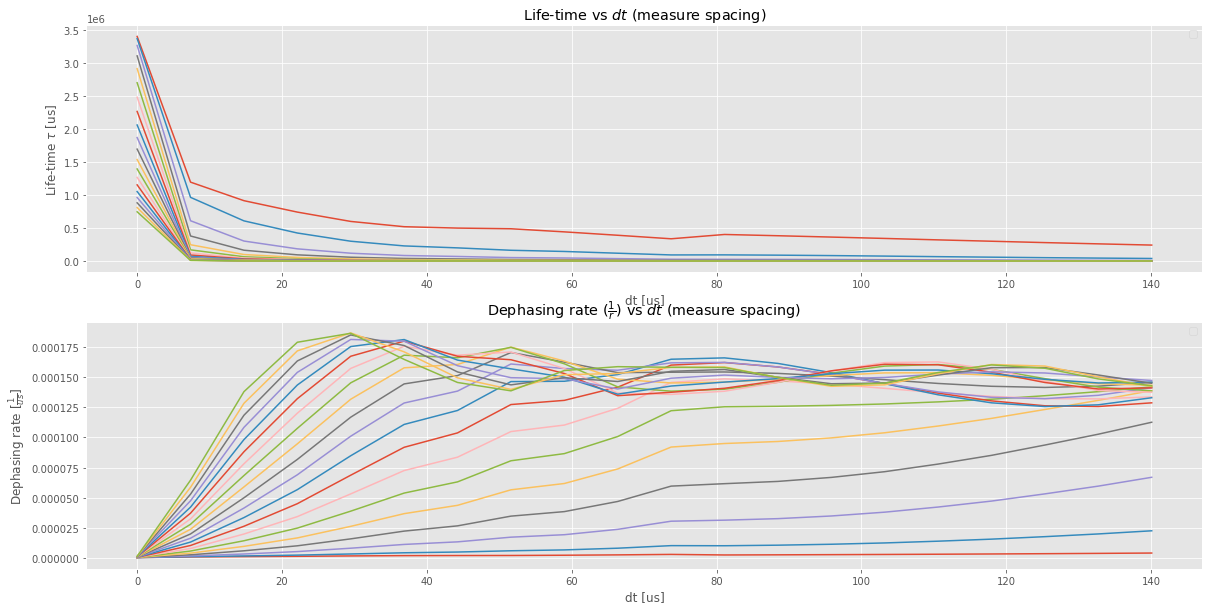

In [182]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(20, 10))

# ====== Life time graphs ======
ax1.set_title('Life-time vs $dt$ (measure spacing)')
ax1.set_xlabel(r'dt [us]')
ax1.set_ylabel(r'Life-time $\tau$ [us]')
ax1.legend([f'$\chi=${chi}' for chi in chi_e_list])

ax1.plot(np.linspace(tlist[0], tlist[t_max], len(tau)), tau)

# ====== Decay rate graphs ======
ax2.set_title(r'Dephasing rate ($\frac{1}{r}$) vs $dt$ (measure spacing)')
ax2.set_xlabel(r'dt [us]')
ax2.set_ylabel(r'Dephasing rate [$\frac{1}{us}$]')
ax2.legend([f'$\chi=${chi}' for chi in chi_e_list])

ax2.plot(np.linspace(tlist[0], tlist[t_max], len(tau)), 1/np.array(tau), label='Life time')


plt.subplots_adjust(hspace=0.2)
plt.show()

#### Countor plots

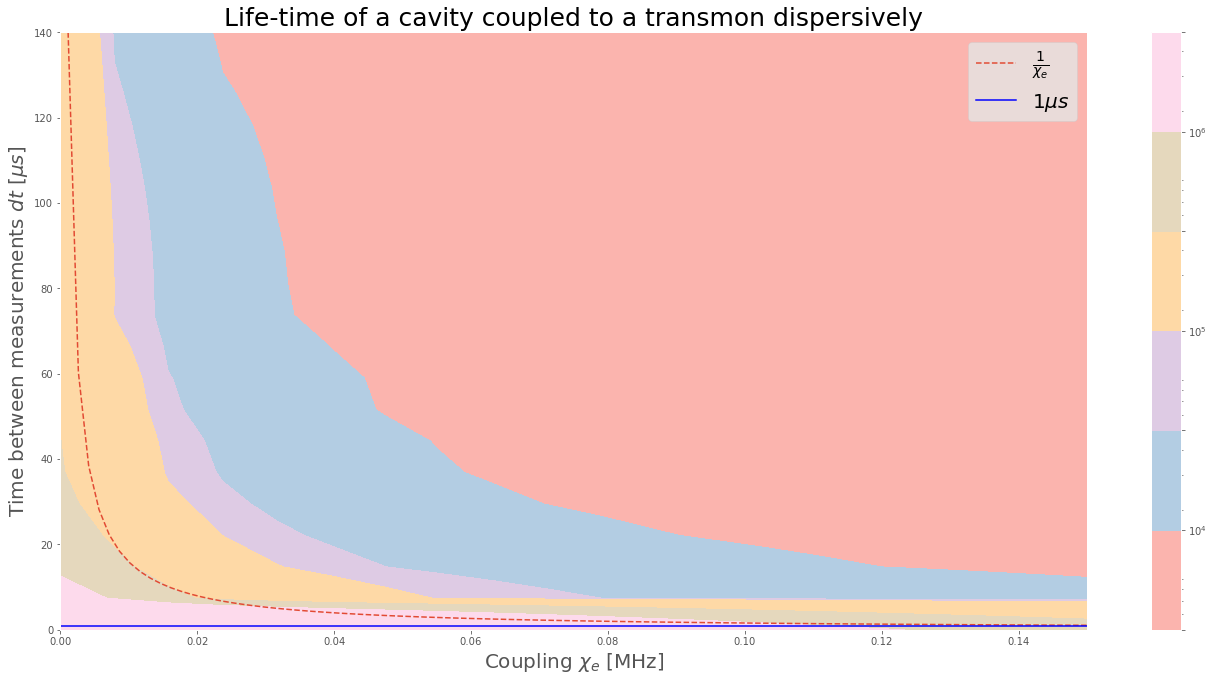

In [183]:
fig, ax=plt.subplots(figsize=(23, 11))

x = chi_e_list
y = np.linspace(tlist[0], tlist[t_max], len(tau))
cp1 = ax.contourf(x, y, tau, levels=[5e3,1e4,5e4,1e5,5e5,1e6,5e6], locator=ticker.LogLocator(), cmap=cm.Pastel1)

chis = np.linspace(1/(t_tot*2*np.pi), chi_e_list[-1],100)
ax.plot(chis, 1/(2*np.pi*chis), '--', label=r'$\frac{1}{\chi_e}$')

ax.axhline(1, color='b', label=r'1$\mu s$')

ax.set_title('Life-time of a cavity coupled to a transmon dispersively', fontsize=25)
ax.set_xlabel(r'Coupling $\chi_e$ [MHz]', fontsize=20)
ax.set_ylabel(r'Time between measurements $dt$ [$\mu s$]', fontsize=20)
ax.legend(fontsize=20)
fig.colorbar(cp1);

### Save results to a file

In [13]:
file_name = r'results/Life-time_of_cavity__' + datetime.datetime.now().strftime("%d-%m-%Y_%H-%M-%S") + '.csv'
np.savetxt(file_name, tau, delimiter=',')